# Convex CNN (No pooling)

This file implements the convex CNN **without** pooling.

Paper: https://arxiv.org/pdf/2101.02429.pdf

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n-project/daniel


In [2]:
import numpy as np 
import cvxpy as cp
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from time import time
import tqdm.notebook as tq

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def load_Fashion_MNIST():
  train_dset = datasets.FashionMNIST('./datasets', train=True, download=True)
  test_dset = datasets.FashionMNIST('./datasets', train=False, download=True)
  X_train =  train_dset.data.numpy()
  y_train = train_dset.targets.numpy()
  X_test = test_dset.data.numpy()
  y_test = test_dset.targets.numpy()

  # We'll do binary classification, so get only first two classes
  X_train = X_train[y_train <= 1]
  y_train = y_train[y_train <= 1]
  X_test = X_test[y_test <= 1]
  y_test = y_test[y_test <= 1]

  # Change type to float
  X_train = X_train.astype(np.float64)
  y_train = y_train.astype(np.float64)
  X_test = X_test.astype(np.float64)
  y_test = y_test.astype(np.float64)

  # Normalize
  X_train = (X_train - 128) / 255
  X_test = (X_test - 128) / 255

  # Expand channel dim
  X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
  X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_Fashion_MNIST()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# # Uncomment this if in Dev mode
NUM_TRAIN, NUM_TEST = 1000, 2000
X_train, y_train = X_train[:NUM_TRAIN], y_train[:NUM_TRAIN]
# X_test, y_test = X_test[:NUM_TEST], y_test[:NUM_TEST]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# #####

(12000, 1, 28, 28) (12000,) (2000, 1, 28, 28) (2000,)
(1000, 1, 28, 28) (1000,) (2000, 1, 28, 28) (2000,)


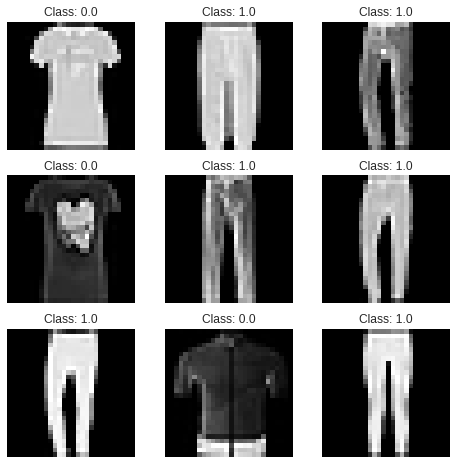

In [4]:
np.random.seed(0)
def visualize_dataset(X, y):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label = X[sample_idx], y[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

visualize_dataset(X_train, y_train)

In [5]:
class Convex_CNN_Solver():
  def __init__(self, beta, max_iters, filter_size, stride, vectorized):
    '''
    Architecture: One conv layer followed by a fully connected layer
    Objective: See Eq. 96
    '''
    self.a, self.b, self.c = 0.09, 0.5, 0.47
    self.beta, self.max_iters = beta, max_iters
    self.F, self.stride = filter_size, stride
    self.vectorized = vectorized

    self.K = None # will be set by self.compute_X_V()

    # Solutions
    self.Z_V = None
    self.Z, self.Z_prime = None, None
    self.Z1, self.Z2, self.Z4 = None, None, None
    self.Z1_prime, self.Z2_prime, self.Z4_prime = None, None, None

  def compute_patches(self, X):
    # @ param X: (N, 1, W, W)
    X_P = torch.nn.functional.unfold(torch.tensor(X),
                                     kernel_size=self.F, 
                                     stride=self.stride, 
                                     padding=0).numpy() #(N, D, K)
    self.K = X_P.shape[2]
    return X_P

  def compute_X_V(self, X_P):
    '''
    Calculates X_V as in Eq. 98. Notice the similarity with the scalar case
    in convex_fc_scalar.py.

    @param X_P: (N, D, K)
    @return X_V: (N, (D**2+D+1)*K)
    '''
    a, b, c = self.a, self.b, self.c
    N, D, K = X_P.shape

    X_V = np.zeros((N, D**2+D+1, K))
    for i in tq.tqdm(range(N)):
      for k in range(K):
        x_ik = X_P[i, :, k:k+1]
        X_V[i, 0:D**2, k] = a * (x_ik @ x_ik.T).reshape(D**2)
        X_V[i, D**2:D**2+D, k] = b * x_ik.reshape(D)
    X_V[:, D**2+D, :] = c

    X_V = X_V.reshape((N, (D**2+D+1)*K))

    return X_V


  def build_Z(self):
    '''
    Note similarity with convex_fc_vector.
    @param K is number of patches per image
    '''
    D, K = self.F ** 2, self.K
    Z, Z_prime, Z_V = [], [], []
    Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = [], [], [], [], [], []

    for k in range(K):
      Z1 += [cp.Variable((D, D), symmetric=True)]
      Z2 += [cp.Variable((D, 1))]
      Z4 += [cp.Variable((1, 1))]

      Z1_prime += [cp.Variable((D, D), symmetric=True)]
      Z2_prime += [cp.Variable((D, 1))]
      Z4_prime += [cp.Variable((1, 1))]

      Z += [cp.vstack([
        cp.hstack((Z1[k], Z2[k])),
        cp.hstack((Z2[k].T, Z4[k]))
      ])]

      Z_prime += [cp.vstack([
        cp.hstack((Z1_prime[k], Z2_prime[k])),
        cp.hstack((Z2_prime[k].T, Z4_prime[k]))
      ])]

    Z_V = cp.hstack([cp.vstack([
      cp.reshape((Z1[k]-Z1_prime[k]), (D**2, 1)),
      (Z2[k]-Z2_prime[k]),
      (Z4[k]-Z4_prime[k])
    ]) for k in range(K)]) # (D**2+D+1, K)

    Z_V = cp.reshape(Z_V, ((D**2+D+1)*K, 1))

    return Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime


  def solve(self, X, y, verbose=True):
    '''
    X.shape = (N, 1, W, W)
    y.shape = (N, )
    beta: regularization strength
    '''
    y = y.reshape((-1,1)) # (N, 1)
    a, b, c = self.a, self.b, self.c
    X_P = self.compute_patches(X) # (N, D, K)
    N, D, K = X_P.shape
    Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = self.build_Z() # Z_V: ((D**2+D+1)*K, 1)
    y_hat = cp.Variable((N, 1))
    constraints = []

    if verbose:
      print(f'X.shape : {X.shape}')    # (N, 1, W, W)
      print(f'y.shape : {y.shape}')    # (N, 1)
      print(f'X_P.shape: {X_P.shape}') # (N, D, K)
      print(f'Z_V.shape: {Z_V.shape}') # (D**2+D+1, K)
      print(f'y_hat.shape: {y_hat.shape}') # (N, 1)

    if self.vectorized:
      X_V = self.compute_X_V(X_P) # (N, (D**2+D+1)*K)
      y_hat = X_V @ Z_V
    else:
      for i in range(N):
        y_i = 0
        for k in range(K):
          x_ik = X_P[i, :, k:k+1]
          quad_term = a * (x_ik.T @ (Z1[k] - Z1_prime[k]) @ x_ik)
          linear_term = b * x_ik.T @ (Z2[k] - Z2_prime[k])
          const_term = c * (Z4[k] - Z4_prime[k])
          y_i += quad_term + linear_term + const_term
        constraints += [y_hat[i] == y_i]

    loss = 0.5 * cp.sum_squares(y_hat - y) + self.beta * cp.sum(Z4 + Z4_prime)
    objective = cp.Minimize(loss)
    for k in range(K):
      constraints += [
          Z[k] >> 0,
          Z_prime[k] >> 0,
          cp.trace(Z1[k]) == Z4[k],
          cp.trace(Z1_prime[k]) == Z4_prime[k],
      ]

    problem = cp.Problem(objective, constraints)
    print(f'##########')
    print('Started...')
    start = time()
    problem.solve(max_iters=self.max_iters, verbose=verbose, warm_start=False)
    end = time()
    print(f'Finished, time: {end-start}')
    print(f'status: {problem.status}')
    print(f'optimal value: {objective.value}')
    print('##########')

    # Save solutions
    self.Z_V = Z_V.value
    self.Z, self.Z_prime = self.values(Z),  self.values(Z_prime)
    self.Z1, self.Z2, self.Z4 = self.values(Z1), self.values(Z2), self.values(Z4)
    self.Z1_prime, self.Z2_prime, self.Z4_prime = self.values(Z1_prime), self.values(Z2_prime), self.values(Z4_prime)

    return None
  
  @staticmethod
  def values(arr):
    return [arr[k].value for k in range(len(arr))]

  def predict(self, X):
    X_P = self.compute_patches(X)
    if self.vectorized:
      X_V = self.compute_X_V(X_P)
      scores = X_V @ self.Z_V
    else:
      N, _, K = X_P.shape
      a, b, c = self.a, self.b, self.c
      Z1, Z2, Z4 = self.Z1, self.Z2, self.Z4
      Z1_prime, Z2_prime, Z4_prime = self.Z1_prime, self.Z2_prime, self.Z4_prime
      scores = np.zeros((N, 1))
      for i in range(N):
        y_i = 0
        for k in range(K):
          x_ik = X_P[i, :, k:k+1]
          quad_term = a * (x_ik.T @ (Z1[k] - Z1_prime[k]) @ x_ik)
          linear_term = b * x_ik.T @ (Z2[k] - Z2_prime[k])
          const_term = c * (Z4[k] - Z4_prime[k])
          y_i += quad_term + linear_term + const_term
        scores[i] = y_i
    return scores.squeeze()

  def calculate_loss(self, y_hat, y):
    loss = 0.5 * np.sum((y - y_hat)**2) + self.beta * np.sum(self.Z4 + self.Z4_prime)
    return loss.squeeze()

  def get_num_neurons(self, tol: float):
    return np.sum(np.linalg.eig(self.Z)[0] > tol) + np.sum(np.linalg.eig(self.Z_prime)[0] > tol)

In [6]:
solver = Convex_CNN_Solver(beta=10**(-6), max_iters=100, filter_size=4, stride=4, vectorized=True)
loss = solver.solve(X_train, y_train, verbose=True)

X.shape : (1000, 1, 28, 28)
y.shape : (1000, 1)
X_P.shape: (1000, 16, 49)
Z_V.shape: (13377, 1)
y_hat.shape: (1000, 1)



##########
Started...
----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 15000646
eps = 1.00e-04, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 14995, constraints m = 16094
Cones:	primal zero / dual free vars: 98
	soc vars: 1002, soc blks: 1
	sd vars: 14994, sd blks: 98
Setup time: 4.27e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.08e+21  4.81e+20  1.00e+00 -9.19e+21  5.90e+20  2.71e+21  4.03e-01 
   100| 7.41e-04  5.90e-04  7.02e-04 -1.10e-03 -4.00e-04  4.29e-16  1.71e+01 
---------------------

In [7]:
scores = solver.predict(X_train)
preds = (scores > 0.5).astype(np.long)
accuracy = np.sum(preds == y_train) / y_train.shape[0]
loss = solver.calculate_loss(scores, y_train)
print(f'train_accuracy: {accuracy}')
print(f'loss: {loss}')


train_accuracy: 1.0
loss: 0.0008672259147097226


In [8]:
scores = solver.predict(X_test)
preds = (scores > 0.5).astype(np.long)
accuracy = np.sum(preds == y_test) / y_test.shape[0]
loss = solver.calculate_loss(scores, y_test)
print(f'test_accuracy: {accuracy}')
print(f'loss: {loss}')


test_accuracy: 0.954
loss: 61.30374696007247


In [9]:
print(f'num_nerons: {solver.get_num_neurons(tol=10**(-4))}')

num_nerons: 1666
